<a href="https://colab.research.google.com/github/mgfalzon/Final-Tutorial/blob/main/ft_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![title](https://github.com/mgfalzon/Final-Tutorial/blob/main/all_pokemons.png?raw=1)

### **Predicting Pokemon Battle Outcomes Through Stats**

Matthew Falzon, Robert Calkins, Michael Bailey

#### **Introduction**

*introduction in progress*

<p>
Pokémon is a video game franchise centered around fictional creatures called 'Pokémon' which humans catch, train, and battle for sport. In the game, the player is tasked with building a team of strong Pokémon which they will use in to challenge other 'Pokemon Trainers'. Most games follow a linear progression in which the player travels from town to town battling powerful trainers known as 'Gym Leaders' that the trainer must defeat in order to collect a gym badge. Once all badges have been collected the player can progress to the Elite Four, four of the most powerful pokemon trainers in the reigion, which the player can battle in succession in order to reach the Regional champion who they can battle in order to become the new champion.
</p>

<br/>
<p>
<em>talk about the battle system</em>
</p>
<br/>


<p>
This tutorial seeks to explore the relationship between a pokemon's characteristics and win percentage in 100 simulated battles. In order to preform our analysis we'll be looking at 3 characterstics, a pokemon's type, their base stats, and finally their legendary status. We want to know if we can use these characterstics in order to predict the outcome of future battles. The Kaggle dataset <a href="https://www.kaggle.com/terminus7/pokemon-challenge">Pokemon- Weedle's Cave</a> by user terminus7 contains two files which will be used to preform our analysis. The first file contains the pokemon charactersitics and the second one contains information about previous battles.
</p>

#### **Python Libraries**

In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re

#### **Importing Data**

In [3]:
path = "https://raw.githubusercontent.com/mgfalzon/Final-Tutorial/main"
combats = pd.read_csv(f"{path}/combats.csv")
pokemon = pd.read_csv(f"{path}/pokemon.csv")

#### **Tidy Data: Pokemon**

In [4]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [5]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [6]:
pokemon.corr()

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,1.000000,0.097712,0.102664,0.094691,0.089199,0.085596,0.012181,0.983428,0.154336
HP,0.097712,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.102664,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.094691,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.089199,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.085596,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.012181,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.983428,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.154336,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


In [7]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [8]:
# Find missing data
pokemon.isna().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

<sub>*Note: type 2 is missing because some pokemon only have one type</sub>

In [9]:
# One pokemon is missing from the data
missing = pokemon[pokemon['Name'].isna()]
missing

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


In [10]:
# Take a look at the surrounding pokemon
miss_id = missing.index[0]
pokemon[miss_id - 3 : miss_id + 3]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
59,60,Psyduck,Water,NaN,50,52,48,65,50,55,1,False
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False


In [11]:
# Use the pokeAPI in order to find the missing pokemon
def pokeAPI(s):
    r = requests.get(f"https://pokeapi.co/api/v2/pokemon/{s}")
    return json.loads(r.content)

In [12]:
# Check the pokemon after Mankey in the pokeAPI
res = pokeAPI('mankey')
res = pokeAPI(res['id'] + 1)
display(res['name'], res['types'], res['stats'])

'primeape'

[{'slot': 1,
  'type': {'name': 'fighting', 'url': 'https://pokeapi.co/api/v2/type/2/'}}]

[{'base_stat': 65,
  'effort': 0,
  'stat': {'name': 'hp', 'url': 'https://pokeapi.co/api/v2/stat/1/'}},
 {'base_stat': 105,
  'effort': 2,
  'stat': {'name': 'attack', 'url': 'https://pokeapi.co/api/v2/stat/2/'}},
 {'base_stat': 60,
  'effort': 0,
  'stat': {'name': 'defense', 'url': 'https://pokeapi.co/api/v2/stat/3/'}},
 {'base_stat': 60,
  'effort': 0,
  'stat': {'name': 'special-attack',
   'url': 'https://pokeapi.co/api/v2/stat/4/'}},
 {'base_stat': 70,
  'effort': 0,
  'stat': {'name': 'special-defense',
   'url': 'https://pokeapi.co/api/v2/stat/5/'}},
 {'base_stat': 95,
  'effort': 0,
  'stat': {'name': 'speed', 'url': 'https://pokeapi.co/api/v2/stat/6/'}}]

In [13]:
# Clean stats for readability
data = {stat['stat']['name'] : stat['base_stat'] for stat in res['stats']}
data['type'] = res['types'][0]['type']['name']
df = pd.DataFrame(data, [res['name']])
display("pokeAPI Data", df)
display("Pokemon Data", missing.iloc[:,1:10])

'pokeAPI Data'

,hp,attack,defense,special-attack,special-defense,speed,type
primeape,65,105,60,60,70,95,fighting


'Pokemon Data'

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
62,NaN,Fighting,NaN,65,105,60,60,70,95


It's a match!

In [14]:
# Update the data
pokemon['Name'] = np.where(pokemon['Name'].isna(), 'Primeape', pokemon['Name'])
pokemon[miss_id - 3 : miss_id + 3]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
59,60,Psyduck,Water,NaN,50,52,48,65,50,55,1,False
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False


#### **Tidy Data: Combats**

In [15]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [16]:
# Insert Loser column
combats['Loser'] = pd.Series(np.where(combats['Winner'] == combats['First_pokemon'], combats['Second_pokemon'], combats['First_pokemon']))
combats.head(3)

,First_pokemon,Second_pokemon,Winner,Loser
0,266,298,298,266
1,702,701,701,702
2,191,668,668,191


In [17]:
# Find missing data
combats.isna().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
Loser             0
dtype: int64

In [18]:
# Generate win and loss counts for each pokemon
wins = combats['Winner'].value_counts().sort_index().rename('Wins')
loss = combats['Loser'].value_counts().sort_index().rename('Loss')

# Verify that each pokemon has at least one loss and one win
display(f"Total Pokemon: {len(pokemon)}")
display(f"Unqiue Winners: {len(wins)}")
display(f"Unqiue Losers: {len(loss)}")

'Total Pokemon: 800'

'Unqiue Winners: 783'

'Unqiue Losers: 784'

17 Pokemon do not appear in the winner column and 16 Pokemon do not appear in the loser column. Let's check to see if any of these Pokemon don't appear in either column.

In [19]:
# Pokemon that did not win or lose (these pokemon did not compete)
ids = [x for x in pokemon['#'] if x not in wins.index and x not in loss.index]
display(ids, pokemon[pokemon['#'].isin(ids)].head())

[12, 33, 46, 66, 78, 90, 144, 183, 236, 322, 419, 479, 556, 618, 655, 782]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False


In [20]:
# Let's drop those pokemon, they won't provide insight for our analysis
pokemon = pokemon[~pokemon['#'].isin(ids)]

In [21]:
# Let's check again to see if each pokemon has at least one loss and one win
display(f"Total Pokemon: {len(pokemon)}")
display(f"Unqiue Winners: {len(wins)}")
display(f"Unqiue Losers: {len(loss)}")

'Total Pokemon: 784'

'Unqiue Winners: 783'

'Unqiue Losers: 784'

There appears to be one pokemon that did not win at all. Let's see who it is

In [22]:
# Pokemon with no wins
worst_pokemon = [x for x in pokemon['#'] if x in loss.index and x not in wins.index][0]
pokemon[pokemon['#'] == worst_pokemon]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False


In [23]:
# Add 0 to wins for Shuckle
wins[worst_pokemon] = 0

In [24]:
# Final verification
display(f"Total Pokemon: {len(pokemon)}")
display(f"Unqiue Winners: {len(wins)}")
display(f"Unqiue Losers: {len(loss)}")

'Total Pokemon: 784'

'Unqiue Winners: 784'

'Unqiue Losers: 784'

#### **Data Exploration**

In [25]:
# Calculate win percentage
res = pd.concat([wins, loss], axis=1)
res['win_loss'] = res['Wins'] / (res['Wins'] + res['Loss'])
res['win_pct']  = (res['win_loss'] * 100).round(1)
res.head()

,Wins,Loss,win_loss,win_pct
1,37,96,0.278195,27.8
2,46,75,0.380165,38.0
3,89,43,0.674242,67.4
4,70,55,0.560000,56.0
5,55,57,0.491071,49.1


In [26]:
# Join with pokemon table
pokemon = pokemon.join(res, on='#')

In [27]:
# Top 50 Pokemon by win percentage
top50 = pokemon.sort_values(by='win_pct', ascending=False).head(50)
top50[['Name', 'win_pct']].head()

,Name,win_pct
154,Mega Aerodactyl,98.4
512,Weavile,97.5
703,Tornadus Therian Forme,96.8
19,Mega Beedrill,96.6
153,Aerodactyl,96.5


In [28]:
# Bottom 50 Pokemon by win percentage
bot50 = pokemon.sort_values(by='win_pct', ascending=True).head(50)
bot50[['Name', 'win_pct']].head()

,Name,win_pct
230,Shuckle,0.0
289,Silcoon,2.2
189,Togepi,2.5
638,Solosis,3.1
236,Slugma,3.3


In [29]:
# Remove Mega Pokemon
pokemon = pokemon[pokemon['Name'].str.match(r'Mega .*') == False]

# Recalculate top and bottom 50
top50 = pokemon.sort_values(by='win_pct', ascending=False).head(50)
bot50 = pokemon.sort_values(by='win_pct', ascending=True).head(50)

pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Loss,win_loss,win_pct
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37,96,0.278195,27.8
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46,75,0.380165,38.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89,43,0.674242,67.4
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55,57,0.491071,49.1
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64,54,0.542373,54.2


In [30]:
# Non-Mega pokemon with most wins
top50[['Name', 'win_pct']].head()

,Name,win_pct
512,Weavile,97.5
703,Tornadus Therian Forme,96.8
153,Aerodactyl,96.5
726,Greninja,96.1
716,Meloetta Pirouette Forme,95.9


In [31]:
# Type frequency
type_freq = pokemon.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('freq')
type_freq = type_freq.sort_values(ascending=False)
pd.DataFrame(type_freq).head()

,,freq
Type 1,Type 2,
Normal,NaN,58
Water,NaN,56
Psychic,NaN,36
Grass,NaN,31
Fire,NaN,28


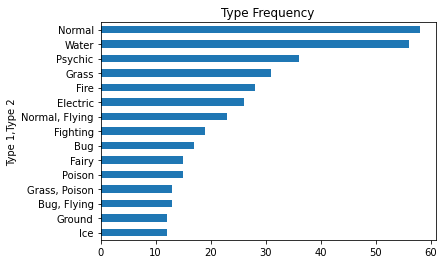

In [32]:
# Graph type frequency
ax = type_freq.head(15).plot.barh()
ax.set_title("Type Frequency")
yticks = [t1 if pd.isna(t2) else f'{t1}, {t2}' for (t1,t2) in type_freq.index]
ax.set_yticklabels(yticks)
ax.invert_yaxis()

In [33]:
# Top 50 pokemon Type frequency
type_freq = top50.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('count').reset_index()
type_freq = type_freq.sort_values(by='count', ascending=False).reset_index(drop=True)
type_freq.head()

,Type 1,Type 2,count
0,Psychic,NaN,5
1,Normal,NaN,5
2,Electric,NaN,5
3,Dark,NaN,3
4,Bug,Flying,2


In [34]:
# Bottom 50 pokemon Type frequency
type_freq = bot50.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('count').reset_index()
type_freq = type_freq.sort_values(by='count', ascending=False).reset_index(drop=True)
type_freq.head()

,Type 1,Type 2,count
0,Bug,NaN,8
1,Psychic,NaN,6
2,Grass,NaN,4
3,Normal,NaN,4
4,Normal,Fairy,3


In [35]:
# Split data by generation
gen = {g:df for g, df in pokemon.groupby(by='Generation')}
gen[1].head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Loss,win_loss,win_pct
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37,96,0.278195,27.8
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46,75,0.380165,38.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89,43,0.674242,67.4
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55,57,0.491071,49.1
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64,54,0.542373,54.2


#### **Data Visualization**

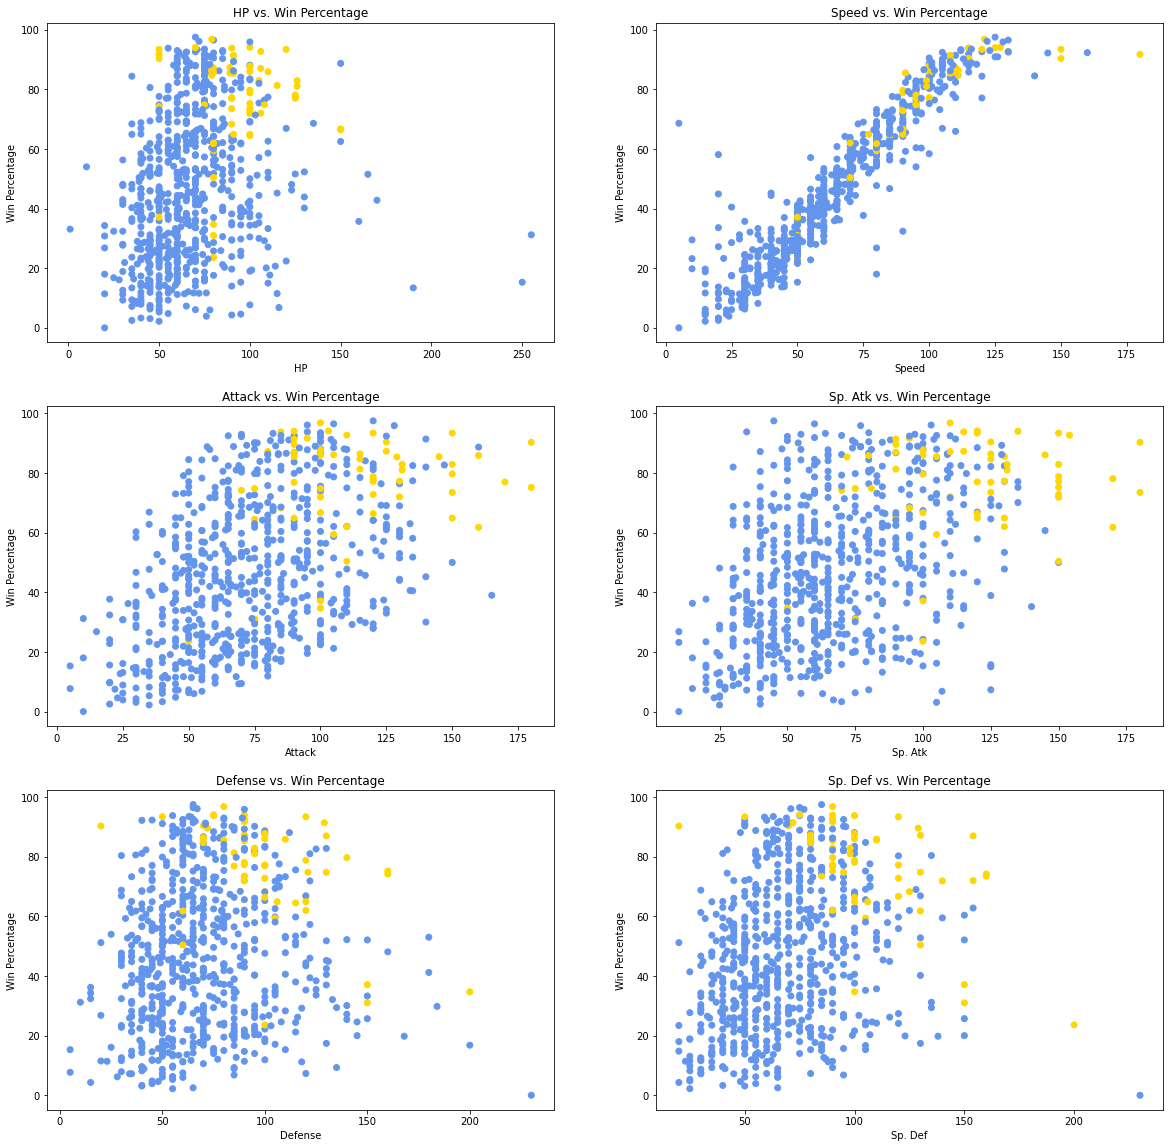

In [36]:
# Graph Base Stats -- Win Percentage
base_stats = ["HP", "Speed", "Attack", "Sp. Atk", "Defense", "Sp. Def"]
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
pts = [(i, j) for i in range(3) for j in range(2)]

color = np.where(pokemon['Legendary'] == True, 'gold', 'cornflowerblue')
for stat, (x,y) in zip(base_stats, pts):
  # Plot stat on subplot
  ax = axs[x, y]
  ax.scatter(stat, "win_pct", data=pokemon, c=color)
  ax.set(title=f'{stat} vs. Win Percentage', xlabel=stat, ylabel='Win Percentage')

  # Line of best fit (this part is wrong/idk if we need it) 
  # Look a speed when enabled
  '''
  x, y = pokemon[stat], pokemon['win_pct']
  m,b = np.polyfit(x, y, 1)
  ax.plot(x, x*m + b)
  '''

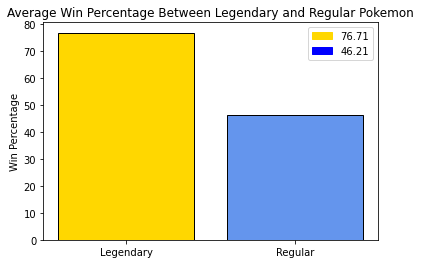

In [37]:
legendary = 0
lsum = 0
regular = 0
rsum = 0
for i, row in pokemon.iterrows():
  if row['Legendary'] == True:
    legendary += 1
    lsum += row['win_pct']
  else:
    regular += 1
    rsum += row['win_pct']

legendary_ave_win_pct = lsum/legendary
regular_ave_win_pct = rsum/regular

labels = ('Legendary', 'Regular')
y_pos = np.arange(len(labels))
performance = [legendary_ave_win_pct, regular_ave_win_pct]
plt.bar(y_pos, performance, align='center', alpha=1, color = ['gold', 'cornflowerblue'], edgecolor = 'black')
plt.xticks(y_pos, labels)
plt.ylabel('Win Percentage')
plt.title('Average Win Percentage Between Legendary and Regular Pokemon')

l = mpatches.Patch(color = 'gold', label = round(legendary_ave_win_pct, 2))
r = mpatches.Patch(color = 'blue', label = round(regular_ave_win_pct, 2))
plt.legend(handles = [l, r])

plt.show()

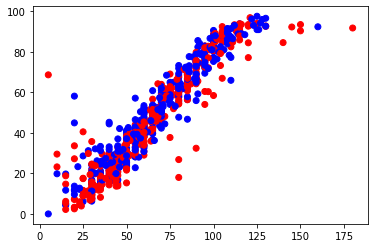

In [39]:
color = np.where((pokemon['Type 2']).isna(), 'red', 'blue')

plt.scatter('Speed', 'win_pct', data=pokemon, c=color)


#### **Analysis**

Game plan:

The combats and test csv's have megas in there so we can do data visualization and analysis comparing legendry's megas and generations win rates and comparisions by those groupings.


Model:

Classification model, 0 for first wins, 1 for second wins.

Features will have to be each of the pokemons types and states and the output will be 0 or 1 depending on who won

Go through the testing data, combine the features of both pokemon, have the label be the number of the winner ????? SVM might be best here. Train test split that shit. Not much we can do with the testing data since we dont have those labels. 